#Session 3  - Assignment


---
Digit Recognizer     
---
Train Accuracy : 98.78%     
Test Accuracy  : 99.09%  

---
Sum Calculator Model    
---
Train Accuracy : 94.11%     
Test Accuracy  : 96.76%     

---

## Data Downloading


Downloading data to colab environment using Pytorch




In [1]:
from torchvision import datasets
datasets.MNIST('data', download=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train

## Importing the necessary modules

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm

## Custom Data Loader

1. Loaded the downloaded data from the colab environment using torch.load method
2. In the "__getitem__" method,
          1) Loaded the data
          2) Created randomm integer
          3) Made a tuple with the expected target variables and input variables

In [3]:
class CustomLoader_MNIST(DataLoader):
    def __init__(self,pt_path):
        self.path = pt_path
        self.data = torch.load(self.path)
        

    def __getitem__(self, idx):
      if torch.is_tensor(idx):
        idx = idx.tolist()

      image, label = self.data[0][idx], self.data[1][idx] 

      randInt = torch.randint(0,9,(1,))
      x1, x2, y1, y2 = image.reshape(1,28,28), randInt, label, label + randInt[0]

      return x1, x2, y1, y2

    def __len__(self):
      return len(self.data[0])

train_data = CustomLoader_MNIST("/content/data/MNIST/processed/training.pt")
test_data = CustomLoader_MNIST("/content/data/MNIST/processed/test.pt")

## Load the data and check of GPU is available for training the model

In [4]:
torch.manual_seed(1)
batch_size = 1024
use_cuda = torch.cuda.is_available()

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, **kwargs)

# Network Architecture
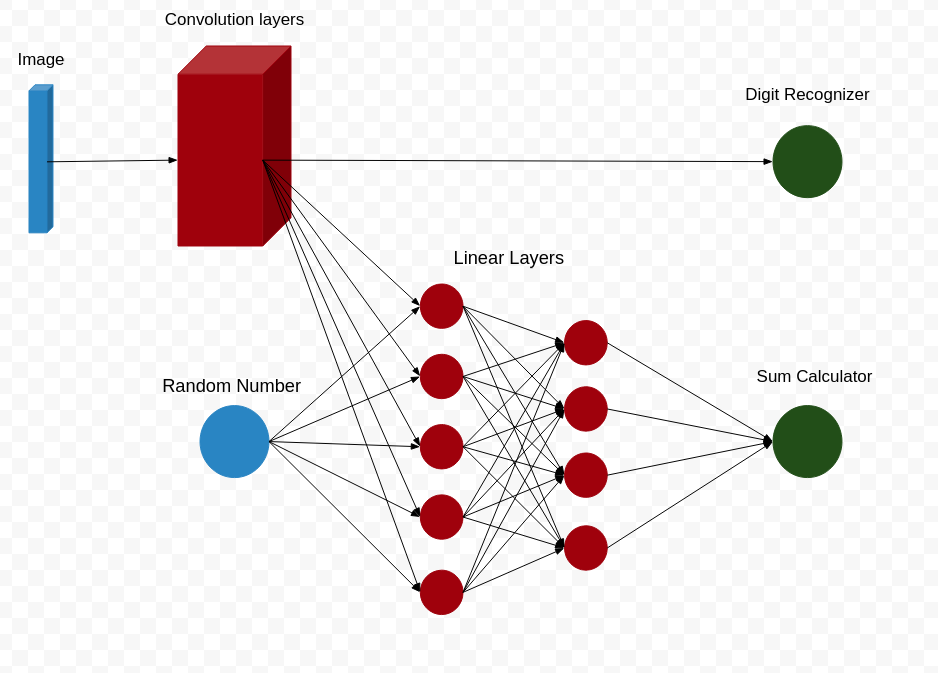

In [9]:

dropout_value = 0.1

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 

        self.dropout = nn.Dropout(dropout_value)
        self.relu = nn.ReLU()
        self.ln1 = nn.Linear(11,30)
        self.ln2 = nn.Linear(30,19)

    def forward(self, img, rnum):        
        img = self.convblock1(img)
        img = self.convblock2(img)
        img = self.convblock3(img)
        img = self.pool1(img)
        img = self.convblock4(img)
        img = self.convblock5(img)
        img = self.convblock6(img)
        img = self.convblock7(img)
        img = self.gap(img)        
        img = self.convblock8(img)
        img = img.view(-1, 10)

        rnum = torch.cat((img, rnum), dim=1)
        rnum = self.ln1(rnum)
        rnum = self.relu(rnum)
        rnum = self.ln2(rnum)

        img = F.log_softmax(img, dim=-1)
        rnum = F.log_softmax(rnum, dim=-1)
        return img, rnum

## Enable cuda for calculation
1. Check if GPU is available for computation
2. if available move the model to GPU

In [10]:

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)

cuda


## Train and Test Functions

Model will be trained by following below steps:
1. Move the below variables to GPU       
    a) x1 - Image      
    b) x2 - Random Number     
    c) y1 - image output     
    d) y2 - Sum of digit in the image and random number     
2. Calculate loss using the Negative loglikelihood function for both digit recognizing and sum calculation
3. Calculate total loss by adding both the values. To improve model accuracy, loss2(Sum calculation network loss) is multiplied by 2 in order to increase its weightage in loss so that the overall loss is magnified for every one unit of loss in Sum calculation network 
4. Plot function will help us visualize improve of accuracy with various epochs





In [15]:
def train(model, device, train_loader, optimizer, epoch):

  model.train()
  pbar = tqdm(train_loader)
  correct1 = 0
  processed = 0
  correct2 = 0

  for batch_idx, (x1, x2, y1, y2) in enumerate(pbar):
    # Data
    x1, x2, y1, y2 = x1.float().to(device), x2.float().to(device), y1.to(device), y2.to(device)
    # Init
    
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict

    y1_pred, y2_pred = model(x1, x2)

    # Calculate loss
    loss1 = F.nll_loss(y1_pred, y1)
    loss2 = F.nll_loss(y2_pred, y2)

    # Cross Entropy Loss
    # loss1 = loss1_(y1_pred, y1)
    # loss2 = loss2_(y2_pred, y2)

    loss =  torch.add(loss1, loss2*2)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()


    
    pred1 = y1_pred.argmax(dim=1, keepdim=True)
    pred2 = y2_pred.argmax(dim=1, keepdim=True)
    
    # get the index of the max log-probability
    correct1 += pred1.eq(y1.view_as(pred1)).sum().item()
    correct2 += pred2.eq(y2.view_as(pred2)).sum().item()
    processed += len(x1)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy_digit={100*correct1/processed:0.2f} Accuracy_Rnum={100*correct2/processed:0.2f}')
    train_acc['Image'].append(100*correct1/processed)
    train_acc['RandomNumber'].append(100*correct2/processed)

def test(model, device, test_loader):
    model.eval()
    correct1 = 0
    correct2 = 0
    with torch.no_grad():
        for x1, x2, y1, y2 in test_loader:
            x1, x2, y1, y2 = x1.float().to(device), x2.float().to(device), y1.to(device), y2.to(device)
            y1_pred, y2_pred = model(x1, x2)
            
            pred1 = y1_pred.argmax(dim=1, keepdim=True)
            pred2 = y2_pred.argmax(dim=1, keepdim=True)
            correct1 += pred1.eq(y1.view_as(pred1)).sum().item()
            correct2 += pred2.eq(y2.view_as(pred2)).sum().item()

    print('Test set: Accuracy_digit={} Accuracy_Rnum={}'.format(100*correct1/len(test_loader.dataset),100*correct2/len(test_loader.dataset)))
    test_acc['Image'].append(100*correct1/len(test_loader.dataset))
    test_acc['RandomNumber'].append(100*correct2/len(test_loader.dataset))



def plot_performance(train_acc, test_acc):
  fig, axs = plt.subplots(2,2,figsize=(15,10))

  axs[0, 0].plot(train_acc['Image'])
  axs[0, 0].set_title("Training - Image")
  axs[0, 1].plot(train_acc['RandomNumber'])
  axs[0, 1].set_title("Training - Random Number Model")
  axs[1, 0].plot(test_acc['Image'])
  axs[1, 0].set_title("Test - Image")
  axs[1, 1].plot(test_acc['RandomNumber'])
  axs[1, 1].set_title("Test - Random Number Model")

## Defining Optimiser and Training the model

  0%|          | 0/59 [00:00<?, ?it/s]

EPOCH: 0


Loss=6.500993251800537 Batch_id=58 Accuracy_digit=39.04 Accuracy_Rnum=10.23: 100%|██████████| 59/59 [00:02<00:00, 26.36it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=66.88 Accuracy_Rnum=12.93
EPOCH: 1


Loss=4.739383220672607 Batch_id=58 Accuracy_digit=78.78 Accuracy_Rnum=18.27: 100%|██████████| 59/59 [00:02<00:00, 29.42it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=92.15 Accuracy_Rnum=22.4
EPOCH: 2


Loss=3.6633598804473877 Batch_id=58 Accuracy_digit=93.71 Accuracy_Rnum=30.52: 100%|██████████| 59/59 [00:02<00:00, 28.97it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=96.1 Accuracy_Rnum=35.59
EPOCH: 3


Loss=2.993901014328003 Batch_id=58 Accuracy_digit=95.74 Accuracy_Rnum=42.06: 100%|██████████| 59/59 [00:02<00:00, 28.69it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=97.2 Accuracy_Rnum=46.67
EPOCH: 4


Loss=2.7342207431793213 Batch_id=58 Accuracy_digit=96.47 Accuracy_Rnum=49.26: 100%|██████████| 59/59 [00:02<00:00, 28.57it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=97.58 Accuracy_Rnum=59.4
EPOCH: 5


Loss=2.4146552085876465 Batch_id=58 Accuracy_digit=97.02 Accuracy_Rnum=55.59: 100%|██████████| 59/59 [00:02<00:00, 28.34it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=97.55 Accuracy_Rnum=55.28
EPOCH: 6


Loss=2.2420058250427246 Batch_id=58 Accuracy_digit=97.30 Accuracy_Rnum=60.75: 100%|██████████| 59/59 [00:02<00:00, 29.03it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.13 Accuracy_Rnum=66.38
EPOCH: 7


Loss=2.2368898391723633 Batch_id=58 Accuracy_digit=97.50 Accuracy_Rnum=64.43: 100%|██████████| 59/59 [00:01<00:00, 29.78it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=97.92 Accuracy_Rnum=68.96
EPOCH: 8


Loss=1.9531879425048828 Batch_id=58 Accuracy_digit=97.63 Accuracy_Rnum=67.61: 100%|██████████| 59/59 [00:02<00:00, 29.47it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.14 Accuracy_Rnum=70.55
EPOCH: 9


Loss=1.9585832357406616 Batch_id=58 Accuracy_digit=97.71 Accuracy_Rnum=69.18: 100%|██████████| 59/59 [00:02<00:00, 27.84it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.19 Accuracy_Rnum=77.1
EPOCH: 10


Loss=1.7635488510131836 Batch_id=58 Accuracy_digit=97.80 Accuracy_Rnum=72.68: 100%|██████████| 59/59 [00:02<00:00, 29.30it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=97.74 Accuracy_Rnum=71.98
EPOCH: 11


Loss=1.7466154098510742 Batch_id=58 Accuracy_digit=97.84 Accuracy_Rnum=74.26: 100%|██████████| 59/59 [00:02<00:00, 29.18it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.45 Accuracy_Rnum=80.75
EPOCH: 12


Loss=1.634602665901184 Batch_id=58 Accuracy_digit=98.01 Accuracy_Rnum=76.40: 100%|██████████| 59/59 [00:02<00:00, 28.14it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.38 Accuracy_Rnum=79.75
EPOCH: 13


Loss=1.6879962682724 Batch_id=58 Accuracy_digit=98.08 Accuracy_Rnum=77.49: 100%|██████████| 59/59 [00:02<00:00, 28.36it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.46 Accuracy_Rnum=80.49
EPOCH: 14


Loss=1.381972074508667 Batch_id=58 Accuracy_digit=98.04 Accuracy_Rnum=78.34: 100%|██████████| 59/59 [00:02<00:00, 28.47it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.54 Accuracy_Rnum=86.15
EPOCH: 15


Loss=1.5450363159179688 Batch_id=58 Accuracy_digit=98.16 Accuracy_Rnum=77.54: 100%|██████████| 59/59 [00:02<00:00, 27.79it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.3 Accuracy_Rnum=80.92
EPOCH: 16


Loss=1.3787333965301514 Batch_id=58 Accuracy_digit=98.19 Accuracy_Rnum=81.11: 100%|██████████| 59/59 [00:02<00:00, 28.18it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.81 Accuracy_Rnum=84.24
EPOCH: 17


Loss=1.488107442855835 Batch_id=58 Accuracy_digit=98.23 Accuracy_Rnum=79.86: 100%|██████████| 59/59 [00:02<00:00, 28.25it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.54 Accuracy_Rnum=84.73
EPOCH: 18


Loss=1.5705029964447021 Batch_id=58 Accuracy_digit=98.33 Accuracy_Rnum=81.19: 100%|██████████| 59/59 [00:02<00:00, 28.76it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.28 Accuracy_Rnum=82.59
EPOCH: 19


Loss=1.2114264965057373 Batch_id=58 Accuracy_digit=98.26 Accuracy_Rnum=82.94: 100%|██████████| 59/59 [00:02<00:00, 27.66it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.78 Accuracy_Rnum=86.82
EPOCH: 20


Loss=1.17485773563385 Batch_id=58 Accuracy_digit=98.31 Accuracy_Rnum=83.61: 100%|██████████| 59/59 [00:02<00:00, 29.07it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.73 Accuracy_Rnum=85.18
EPOCH: 21


Loss=1.1621050834655762 Batch_id=58 Accuracy_digit=98.47 Accuracy_Rnum=84.02: 100%|██████████| 59/59 [00:02<00:00, 27.57it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.76 Accuracy_Rnum=88.72
EPOCH: 22


Loss=1.0199530124664307 Batch_id=58 Accuracy_digit=98.39 Accuracy_Rnum=84.74: 100%|██████████| 59/59 [00:02<00:00, 27.31it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.96 Accuracy_Rnum=87.91
EPOCH: 23


Loss=1.1542844772338867 Batch_id=58 Accuracy_digit=98.50 Accuracy_Rnum=85.85: 100%|██████████| 59/59 [00:02<00:00, 26.65it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.86 Accuracy_Rnum=85.5
EPOCH: 24


Loss=1.152119755744934 Batch_id=58 Accuracy_digit=98.42 Accuracy_Rnum=86.20: 100%|██████████| 59/59 [00:02<00:00, 28.71it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.9 Accuracy_Rnum=85.52
EPOCH: 25


Loss=1.141952395439148 Batch_id=58 Accuracy_digit=98.45 Accuracy_Rnum=86.03: 100%|██████████| 59/59 [00:02<00:00, 28.23it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.91 Accuracy_Rnum=88.65
EPOCH: 26


Loss=0.8619004487991333 Batch_id=58 Accuracy_digit=98.55 Accuracy_Rnum=88.48: 100%|██████████| 59/59 [00:02<00:00, 27.58it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.95 Accuracy_Rnum=92.85
EPOCH: 27


Loss=0.9954967498779297 Batch_id=58 Accuracy_digit=98.59 Accuracy_Rnum=87.52: 100%|██████████| 59/59 [00:02<00:00, 27.80it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.01 Accuracy_Rnum=94.04
EPOCH: 28


Loss=0.8532682061195374 Batch_id=58 Accuracy_digit=98.55 Accuracy_Rnum=88.02: 100%|██████████| 59/59 [00:02<00:00, 27.96it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.88 Accuracy_Rnum=89.65
EPOCH: 29


Loss=1.0336222648620605 Batch_id=58 Accuracy_digit=98.51 Accuracy_Rnum=88.37: 100%|██████████| 59/59 [00:02<00:00, 27.74it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.93 Accuracy_Rnum=93.72
EPOCH: 30


Loss=0.7852633595466614 Batch_id=58 Accuracy_digit=98.59 Accuracy_Rnum=89.62: 100%|██████████| 59/59 [00:02<00:00, 27.18it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.74 Accuracy_Rnum=92.13
EPOCH: 31


Loss=0.7725012302398682 Batch_id=58 Accuracy_digit=98.69 Accuracy_Rnum=90.37: 100%|██████████| 59/59 [00:02<00:00, 28.78it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.51 Accuracy_Rnum=90.61
EPOCH: 32


Loss=0.9523015022277832 Batch_id=58 Accuracy_digit=98.56 Accuracy_Rnum=89.70: 100%|██████████| 59/59 [00:02<00:00, 27.75it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.9 Accuracy_Rnum=95.27
EPOCH: 33


Loss=0.7447466850280762 Batch_id=58 Accuracy_digit=98.60 Accuracy_Rnum=90.74: 100%|██████████| 59/59 [00:02<00:00, 27.91it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.01 Accuracy_Rnum=93.84
EPOCH: 34


Loss=0.7242580652236938 Batch_id=58 Accuracy_digit=98.71 Accuracy_Rnum=91.30: 100%|██████████| 59/59 [00:02<00:00, 27.79it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.92 Accuracy_Rnum=94.94
EPOCH: 35


Loss=1.1448113918304443 Batch_id=58 Accuracy_digit=98.63 Accuracy_Rnum=91.33: 100%|██████████| 59/59 [00:02<00:00, 27.74it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.79 Accuracy_Rnum=93.69
EPOCH: 36


Loss=0.7723993062973022 Batch_id=58 Accuracy_digit=98.68 Accuracy_Rnum=91.07: 100%|██████████| 59/59 [00:02<00:00, 27.58it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.7 Accuracy_Rnum=93.12
EPOCH: 37


Loss=0.5214654803276062 Batch_id=58 Accuracy_digit=98.68 Accuracy_Rnum=91.80: 100%|██████████| 59/59 [00:02<00:00, 27.42it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.03 Accuracy_Rnum=94.73
EPOCH: 38


Loss=0.6865896582603455 Batch_id=58 Accuracy_digit=98.69 Accuracy_Rnum=92.48: 100%|██████████| 59/59 [00:02<00:00, 28.03it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.83 Accuracy_Rnum=93.87
EPOCH: 39


Loss=0.7113961577415466 Batch_id=58 Accuracy_digit=98.67 Accuracy_Rnum=92.17: 100%|██████████| 59/59 [00:02<00:00, 29.13it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.04 Accuracy_Rnum=95.23
EPOCH: 40


Loss=0.6927061676979065 Batch_id=58 Accuracy_digit=98.68 Accuracy_Rnum=92.11: 100%|██████████| 59/59 [00:02<00:00, 26.87it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.06 Accuracy_Rnum=95.88
EPOCH: 41


Loss=0.7832690477371216 Batch_id=58 Accuracy_digit=98.70 Accuracy_Rnum=90.91: 100%|██████████| 59/59 [00:02<00:00, 29.12it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.01 Accuracy_Rnum=95.08
EPOCH: 42


Loss=0.9161985516548157 Batch_id=58 Accuracy_digit=98.76 Accuracy_Rnum=92.52: 100%|██████████| 59/59 [00:02<00:00, 29.41it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.92 Accuracy_Rnum=95.75
EPOCH: 43


Loss=0.5093508362770081 Batch_id=58 Accuracy_digit=98.65 Accuracy_Rnum=91.41: 100%|██████████| 59/59 [00:02<00:00, 28.70it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.93 Accuracy_Rnum=95.29
EPOCH: 44


Loss=0.7511418461799622 Batch_id=58 Accuracy_digit=98.76 Accuracy_Rnum=93.08: 100%|██████████| 59/59 [00:02<00:00, 27.96it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.03 Accuracy_Rnum=95.67
EPOCH: 45


Loss=0.7434156537055969 Batch_id=58 Accuracy_digit=98.80 Accuracy_Rnum=93.62: 100%|██████████| 59/59 [00:02<00:00, 28.63it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.1 Accuracy_Rnum=95.93
EPOCH: 46


Loss=0.7201598882675171 Batch_id=58 Accuracy_digit=98.69 Accuracy_Rnum=93.57: 100%|██████████| 59/59 [00:02<00:00, 28.23it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.11 Accuracy_Rnum=95.02
EPOCH: 47


Loss=0.8479816317558289 Batch_id=58 Accuracy_digit=98.79 Accuracy_Rnum=92.85: 100%|██████████| 59/59 [00:02<00:00, 28.98it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.05 Accuracy_Rnum=96.5
EPOCH: 48


Loss=0.4831181764602661 Batch_id=58 Accuracy_digit=98.79 Accuracy_Rnum=94.17: 100%|██████████| 59/59 [00:02<00:00, 28.54it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.88 Accuracy_Rnum=95.94
EPOCH: 49


Loss=0.8443437814712524 Batch_id=58 Accuracy_digit=98.78 Accuracy_Rnum=94.11: 100%|██████████| 59/59 [00:02<00:00, 29.28it/s]


Test set: Accuracy_digit=99.09 Accuracy_Rnum=96.76


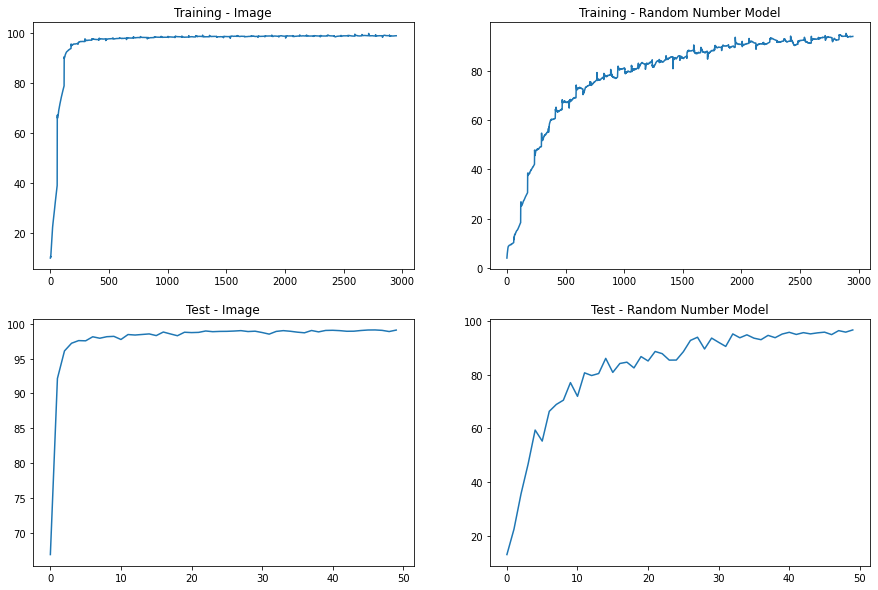

In [16]:
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim

train_losses = []
test_losses =  []
train_acc =  {'Image': [], 'RandomNumber': []}
test_acc = {'Image': [], 'RandomNumber': []}

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9)

EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

plot_performance(train_acc, test_acc)